In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pranavharad012","key":"9223bae60ab6309fe9255534035a676c"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d alsaniipe/flowerdatasets
!unzip flowerdatasets.zip -d flowers


Dataset URL: https://www.kaggle.com/datasets/alsaniipe/flowerdatasets
License(s): apache-2.0
  0% 0.00/57.8M [00:00<?, ?B/s]
100% 57.8M/57.8M [00:00<00:00, 1.40GB/s]
Archive:  flowerdatasets.zip
  inflating: flowers/flowers/train/bluebell/image_0251.jpg  
  inflating: flowers/flowers/train/bluebell/image_0252.jpg  
  inflating: flowers/flowers/train/bluebell/image_0253.jpg  
  inflating: flowers/flowers/train/bluebell/image_0254.jpg  
  inflating: flowers/flowers/train/bluebell/image_0255.jpg  
  inflating: flowers/flowers/train/bluebell/image_0256.jpg  
  inflating: flowers/flowers/train/bluebell/image_0257.jpg  
  inflating: flowers/flowers/train/bluebell/image_0258.jpg  
  inflating: flowers/flowers/train/bluebell/image_0259.jpg  
  inflating: flowers/flowers/train/bluebell/image_0260.jpg  
  inflating: flowers/flowers/train/bluebell/image_0261.jpg  
  inflating: flowers/flowers/train/bluebell/image_0262.jpg  
  inflating: flowers/flowers/train/bluebell/image_0263.jpg  
  inflating:

In [17]:
import os, cv2, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

# Select 5 sample images from pansy folder
path = "flowers/flowers/train/pansy"
image_files = [os.path.join(path, f) for f in os.listdir(path)[:5]]
print("Selected images:")
for f in image_files: print(f)


Selected images:
flowers/flowers/train/pansy/image_1343.jpg
flowers/flowers/train/pansy/image_1356.jpg
flowers/flowers/train/pansy/image_1358.jpg
flowers/flowers/train/pansy/image_1327.jpg
flowers/flowers/train/pansy/image_1330.jpg


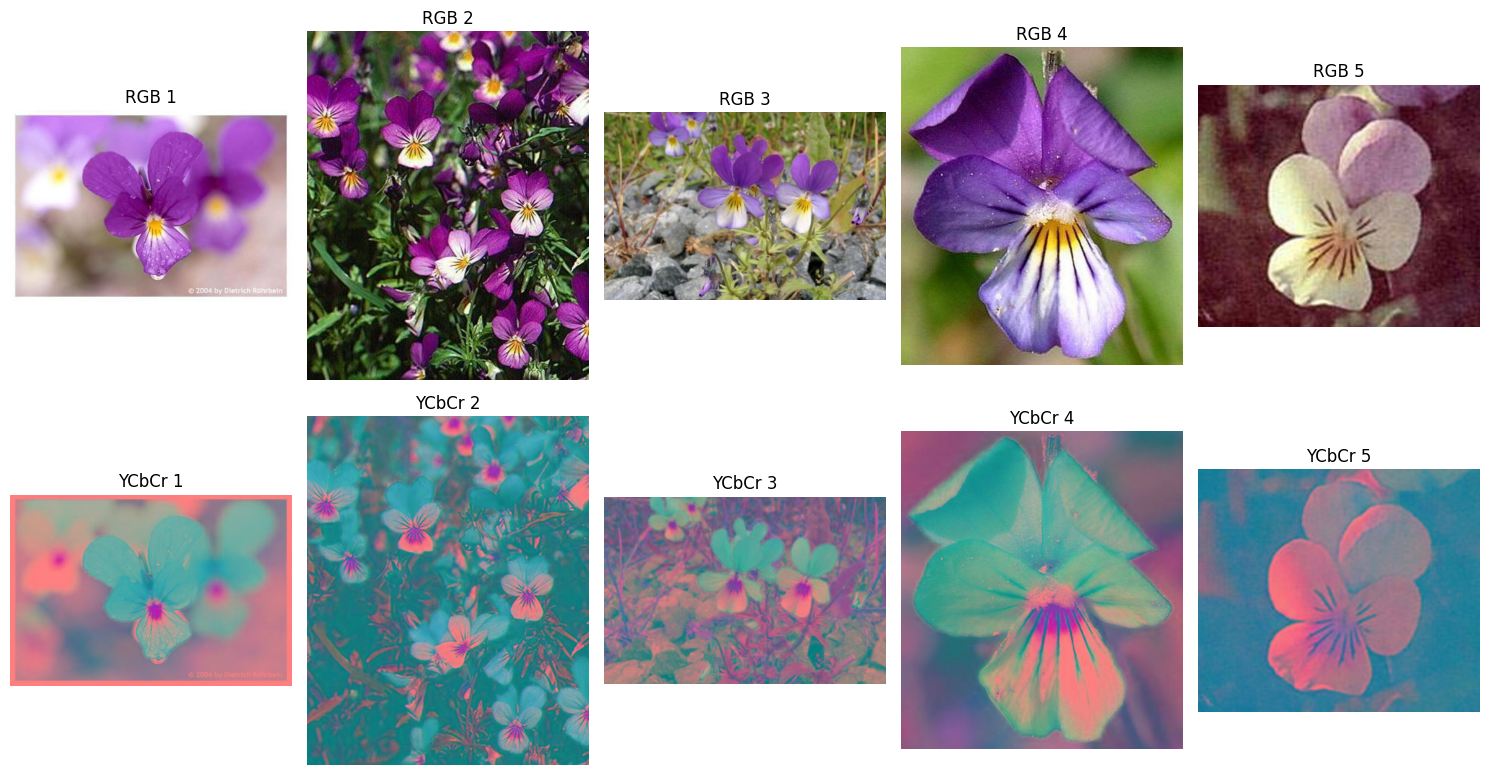

In [18]:
plt.figure(figsize=(15,8))

for idx, img_path in enumerate(image_files):
    img = np.array(Image.open(img_path).convert('RGB')).astype(np.float32)
    R, G, B = img[...,0], img[...,1], img[...,2]

    # RGB → YCbCr conversion
    Y  = 0.299*R + 0.587*G + 0.114*B
    Cb = -0.16874*R - 0.33126*G + 0.5*B + 128
    Cr = 0.5*R - 0.41869*G - 0.08131*B + 128

    YCbCr_img = np.stack([
        np.clip(Y,0,255), np.clip(Cb,0,255), np.clip(Cr,0,255)
    ], axis=-1).astype(np.uint8)

    # Show RGB and YCbCr
    plt.subplot(2,5,idx+1)
    plt.imshow(img.astype(np.uint8))
    plt.title(f"RGB {idx+1}")
    plt.axis("off")

    plt.subplot(2,5,idx+6)
    plt.imshow(YCbCr_img)
    plt.title(f"YCbCr {idx+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [19]:
# Zigzag order generation
zigzag_idx = [(i, j) for s in range(15)
              for i in range(8) for j in range(8)
              if i+j == s]
def zigzag(block):
    return np.array([block[i,j] for (i,j) in zigzag_idx if i<8 and j<8])

# Huffman (simplified)
class Node:
    def __init__(self, sym, freq):
        self.sym, self.freq = sym, freq
        self.left = self.right = None

def build_huffman(symbols):
    freq = Counter(symbols)
    nodes = [Node(s,f) for s,f in freq.items()]
    while len(nodes)>1:
        nodes = sorted(nodes, key=lambda n:n.freq)
        a,b = nodes.pop(0), nodes.pop(0)
        parent = Node(None, a.freq+b.freq)
        parent.left, parent.right = a,b
        nodes.append(parent)
    codes={}
    def make_code(n,p=""):
        if n.sym is not None: codes[n.sym]=p
        else:
            make_code(n.left,p+"0")
            make_code(n.right,p+"1")
    make_code(nodes[0])
    return codes

def huff_encode(symbols,codes):
    return ''.join(codes[s] for s in symbols)


In [20]:
QY = np.array([
 [16,11,10,16,24,40,51,61],
 [12,12,14,19,26,58,60,55],
 [14,13,16,24,40,57,69,56],
 [14,17,22,29,51,87,80,62],
 [18,22,37,56,68,109,103,77],
 [24,35,55,64,81,104,113,92],
 [49,64,78,87,103,121,120,101],
 [72,92,95,98,112,100,103,99]
])

QC = np.array([
 [17,18,24,47,99,99,99,99],
 [18,21,26,66,99,99,99,99],
 [24,26,56,99,99,99,99,99],
 [47,66,99,99,99,99,99,99],
 [99,99,99,99,99,99,99,99],
 [99,99,99,99,99,99,99,99],
 [99,99,99,99,99,99,99,99],
 [99,99,99,99,99,99,99,99]
])


In [21]:
# Choose one image to analyze deeply
img_path = image_files[0]
img = np.array(Image.open(img_path).convert('RGB')).astype(np.float32)
H, W, _ = img.shape
print("Processing image:", img_path)
print("Original shape:", img.shape)

# RGB → YCbCr
Y  = 0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]
Cb = -0.16874*img[...,0] - 0.33126*img[...,1] + 0.5*img[...,2] + 128
Cr = 0.5*img[...,0] - 0.41869*img[...,1] - 0.08131*img[...,2] + 128

# Pad to multiple of 8
H8, W8 = (H+7)//8*8, (W+7)//8*8
Y = np.pad(Y, ((0,H8-H),(0,W8-W)), 'constant')
Cb = np.pad(Cb, ((0,H8-H),(0,W8-W)), 'constant')
Cr = np.pad(Cr, ((0,H8-H),(0,W8-W)), 'constant')

symbols = []
prev_dc = 0
for channel, Q in zip([Y, Cb, Cr], [QY, QC, QC]):
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = channel[i:i+8, j:j+8] - 128
            dct = cv2.dct(blk)
            q = np.round(dct/Q).astype(int)
            zz = zigzag(q)
            dc_diff = zz[0]-prev_dc
            prev_dc = zz[0]
            symbols.append(("D", dc_diff))
            run=0
            for v in zz[1:]:
                if v==0: run+=1
                else:
                    symbols.append(("A",run,v)); run=0
            symbols.append(("A",0,0))

codes = build_huffman(symbols)
bitstream = huff_encode(symbols, codes)
orig_bits = H*W*24
comp_bits = len(bitstream)
ratio = orig_bits/comp_bits

print(f"\nOriginal bits: {orig_bits}")
print(f"Compressed bits: {comp_bits}")
print(f"Compression Ratio: {ratio:.2f}:1")


Processing image: flowers/flowers/train/pansy/image_1343.jpg
Original shape: (499, 736, 3)

Original bits: 8814336
Compressed bits: 270522
Compression Ratio: 32.58:1


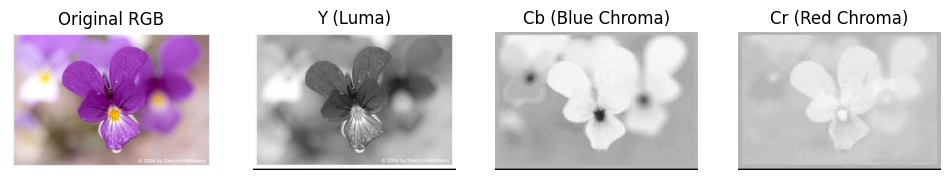

In [24]:
Y_disp  = np.clip(Y,0,255).astype(np.uint8)
Cb_disp = np.clip(Cb,0,255).astype(np.uint8)
Cr_disp = np.clip(Cr,0,255).astype(np.uint8)
YCbCr_img = np.stack([Y_disp, Cb_disp, Cr_disp], axis=-1)

plt.figure(figsize=(12,6))
plt.subplot(1,4,1); plt.imshow(img.astype(np.uint8)); plt.title("Original RGB"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(Y_disp, cmap="gray"); plt.title("Y (Luma)"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(Cb_disp, cmap="gray"); plt.title("Cb (Blue Chroma)"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(Cr_disp, cmap="gray"); plt.title("Cr (Red Chroma)"); plt.axis("off")
plt.show()


In [26]:
# Reconstruct image using inverse DCT
Y_rec = np.zeros_like(Y)
Cb_rec = np.zeros_like(Cb)
Cr_rec = np.zeros_like(Cr)

for channel, Q, rec in zip([Y, Cb, Cr], [QY, QC, QC], [Y_rec, Cb_rec, Cr_rec]):
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = channel[i:i+8, j:j+8] - 128
            # Cast to float32 before DCT
            dct = cv2.dct(blk.astype(np.float32))
            q = np.round(dct / Q).astype(int)
            deq = q * Q
            # Cast to float32 before IDCT
            rec_blk = cv2.idct(deq.astype(np.float32)) + 128
            rec[i:i+8, j:j+8] = rec_blk

# Clip to original dimensions
Y_rec = Y_rec[:H, :W]
Cb_rec = Cb_rec[:H, :W]
Cr_rec = Cr_rec[:H, :W]

# Merge YCbCr → RGB
# Ensure the channels are uint8 before merging for display
rec_img = cv2.merge([Y_rec.astype(np.uint8), Cb_rec.astype(np.uint8), Cr_rec.astype(np.uint8)])
rec_img_rgb = cv2.cvtColor(rec_img, cv2.COLOR_YCrCb2RGB)

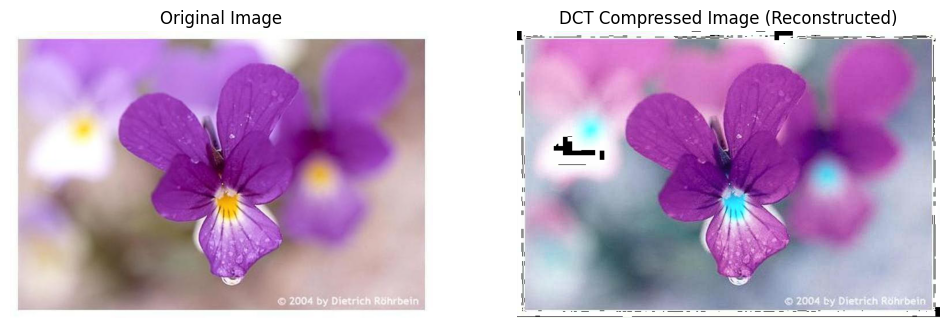

In [27]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img.astype(np.uint8))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(np.clip(rec_img_rgb, 0, 255))
plt.title("DCT Compressed Image (Reconstructed)")
plt.axis("off")
plt.show()


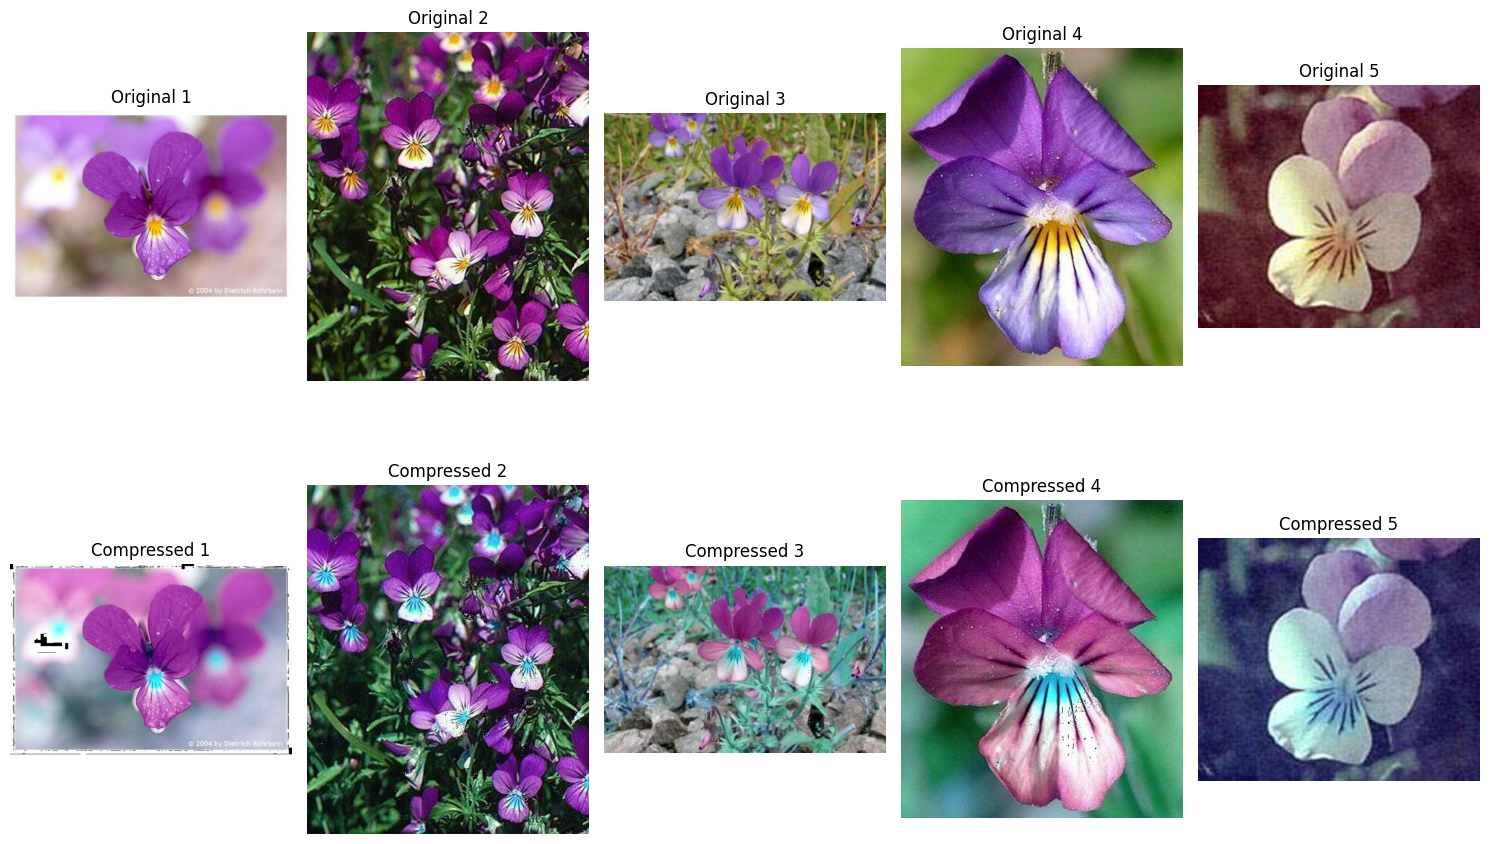

In [29]:
plt.figure(figsize=(15, 10))

for idx, img_path in enumerate(image_files):
    # Load and process original image
    img = np.array(Image.open(img_path).convert('RGB')).astype(np.float32)
    H, W, _ = img.shape

    # RGB → YCbCr
    Y  = 0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]
    Cb = -0.16874*img[...,0] - 0.33126*img[...,1] + 0.5*img[...,2] + 128
    Cr = 0.5*img[...,0] - 0.41869*img[...,1] - 0.08131*img[...,2] + 128

    # Pad to multiple of 8
    H8, W8 = (H+7)//8*8, (W+7)//8*8
    Y = np.pad(Y, ((0,H8-H),(0,W8-W)), 'constant')
    Cb = np.pad(Cb, ((0,H8-H),(0,W8-W)), 'constant')
    Cr = np.pad(Cr, ((0,H8-H),(0,W8-W)), 'constant')

    # Reconstruct image using inverse DCT
    Y_rec = np.zeros_like(Y)
    Cb_rec = np.zeros_like(Cb)
    Cr_rec = np.zeros_like(Cr)

    for channel, Q, rec in zip([Y, Cb, Cr], [QY, QC, QC], [Y_rec, Cb_rec, Cr_rec]):
        for i in range(0, H8, 8):
            for j in range(0, W8, 8):
                blk = channel[i:i+8, j:j+8] - 128
                # Cast to float32 before DCT
                dct = cv2.dct(blk.astype(np.float32))
                q = np.round(dct / Q).astype(int)
                deq = q * Q
                # Cast to float32 before IDCT
                rec_blk = cv2.idct(deq.astype(np.float32)) + 128
                rec[i:i+8, j:j+8] = rec_blk

    # Clip to original dimensions
    Y_rec = Y_rec[:H, :W]
    Cb_rec = Cb_rec[:H, :W]
    Cr_rec = Cr_rec[:H, :W]

    # Merge YCbCr → RGB
    rec_img = cv2.merge([Y_rec.astype(np.uint8), Cb_rec.astype(np.uint8), Cr_rec.astype(np.uint8)])
    rec_img_rgb = cv2.cvtColor(rec_img, cv2.COLOR_YCrCb2RGB)


    # Display original and reconstructed images
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img.astype(np.uint8))
    plt.title(f"Original {idx+1}")
    plt.axis("off")

    plt.subplot(2, 5, idx + 6)
    plt.imshow(np.clip(rec_img_rgb, 0, 255))
    plt.title(f"Compressed {idx+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [30]:
import math

mse = np.mean((img - rec_img_rgb) ** 2)
if mse == 0:
    psnr = 100
else:
    psnr = 20 * math.log10(255.0 / math.sqrt(mse))
print(f"PSNR between Original and DCT Compressed Image: {psnr:.2f} dB")


PSNR between Original and DCT Compressed Image: 17.24 dB
